In [37]:
# https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
# https://www.tensorflow.org/decision_forests/tutorials/predict_colab
# https://www.tensorflow.org/decision_forests/tutorials/advanced_colab 

from google.cloud import bigquery

import pandas as pd
import numpy as np

import math
import os

import tensorflow as tf
print(tf.__version__)


#https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
#https://developers.google.com/machine-learning/crash-course/classification/accuracy

2.12.0


In [38]:
#pip install tensorflow_decision_forests --upgrade --user
import tensorflow_decision_forests as tfdf
print(tfdf.__version__)

1.4.0


# Variable to Configuration

In [70]:
model_tree_type=1# 1= xgboost  2=random forest
option_cate_feature=1 # the best formance    # 1=numberice hour 2. range hour
hyperparameter_template=False

#labelCol='label_multi_severity'
labelCol='label_binary_severity'

#Others are more proper than Accuracy in this case AUC,Recall,F1  (F1 provide  since tensorflow 1.13

model_prefix="demo2"
bucket_name="gs://demo2-tf-incident-pongthorn"

In [71]:
projectId='pongthorn'
dataset_id='SMartML'

train_name='train2_incident'
test_name='test2_incident'


train_table_id=f"{projectId}.{dataset_id}.{train_name}"
test_tabel_id=f"{projectId}.{dataset_id}.{test_name}"
print(f"train-ds = {train_table_id}")
print(f"test-ds = {test_tabel_id}")

train-ds = pongthorn.SMartML.train2_incident
test-ds = pongthorn.SMartML.test2_incident


In [72]:
if  labelCol=='label_multi_severity':
    if model_tree_type==1:
        _model=f'{model_prefix}_multi_gbt_tf_model'
    else:
         _model=f'{model_prefix}_multi_rf_tf__model'
else:
    if model_tree_type==1:
        _model=f'{model_prefix}_binary_gbt_tf_model'
    else:
         _model=f'{model_prefix}_binary_rf_tf_model'

if option_cate_feature==1:
    
    cateCols=['sla','product_type','brand','service_type','incident_type']
    numbericCols=['open_to_close_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_binary_severity']
    else:
      unusedCols=['id','severity_id','severity_name','range_open_to_close_hour','label_multi_severity']  
else:
    # cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour','range_response_to_resolved_hour']
    cateCols=['sla','product_type','brand','service_type','incident_type','range_open_to_close_hour']
    numbericCols=[]
    #unusedCols=['id','severity_id','severity_name','label_binary_severity','open_to_close_hour','response_to_resolved_hour']
    if labelCol=='label_multi_severity':
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_binary_severity']
    else:
     unusedCols=['id','severity_id','severity_name','open_to_close_hour','label_multi_severity']   
    
    _model=f"{_model}_range_hour"
 


print(f"CateCols : {cateCols}")
print(f"NumbericCols : {numbericCols}")
print(f"UnusedCols : {unusedCols}")

model_gs_path=f"{bucket_name}/{_model}"
print(model_gs_path)
#model_local_path=_model

CateCols : ['sla', 'product_type', 'brand', 'service_type', 'incident_type']
NumbericCols : ['open_to_close_hour']
UnusedCols : ['id', 'severity_id', 'severity_name', 'range_open_to_close_hour', 'label_multi_severity']
gs://demo2-tf-incident-pongthorn/demo2_binary_gbt_tf_model


# Load & Prepare Data

In [73]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 
 return df

def load_data_bq(sql:str):
 
 query_result=client.query(sql)
 df=query_result.to_dataframe()
 df =df.drop(columns=unusedCols)
 df[labelCol]=df[labelCol].astype('int64') 
 df=df[[labelCol]+cateCols+numbericCols]   
  
 return df

In [74]:
client = bigquery.Client(project=projectId)

train=load_data_bq(f"SELECT * FROM {train_table_id}")
test=load_data_bq(f"SELECT * FROM {test_tabel_id}")

print(train.info())

print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  3004 non-null   int64  
 1   sla                    3004 non-null   object 
 2   product_type           3004 non-null   object 
 3   brand                  3004 non-null   object 
 4   service_type           3004 non-null   object 
 5   incident_type          3004 non-null   object 
 6   open_to_close_hour     3004 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 164.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   label_binary_severity  751 non-null    int64  
 1   sla                    751 non-null    object 
 2   product_type           751 non-null    o

# Explore & Visualize Target Class Label

In [75]:
classes_train = list(train[labelCol].unique())
classes_test = list(test[labelCol].unique())

set_classes=set(classes_train) & set(classes_test)
classes=list(set_classes)
print(classes)



[0, 1]


1(Critical) in Train=1587 and  1(Critical) in Test=395
Train: Ratio of 1(Critical) to AllLabels is 0.53
Test: Ratio of 1(Critical) to AllLabels is 0.53


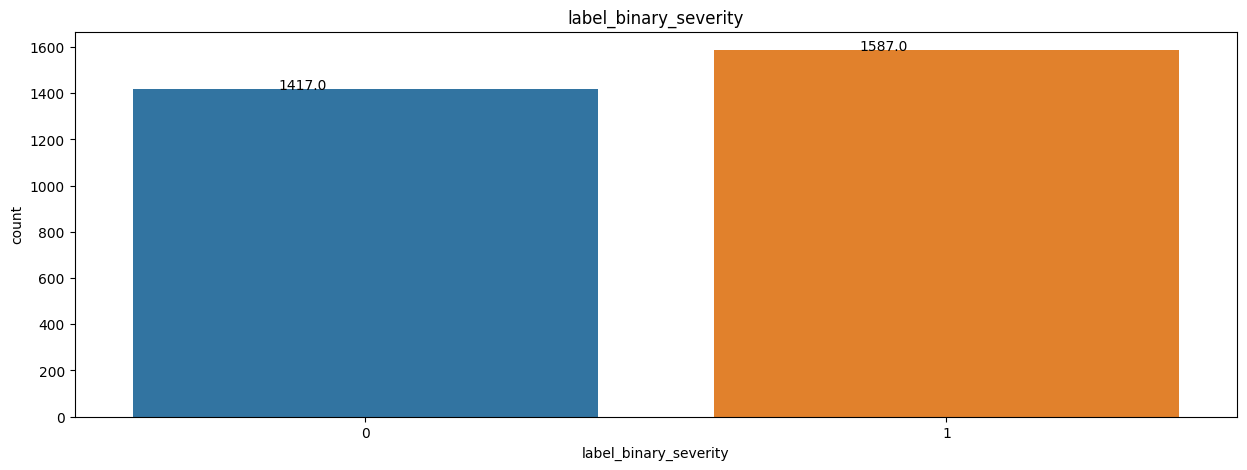

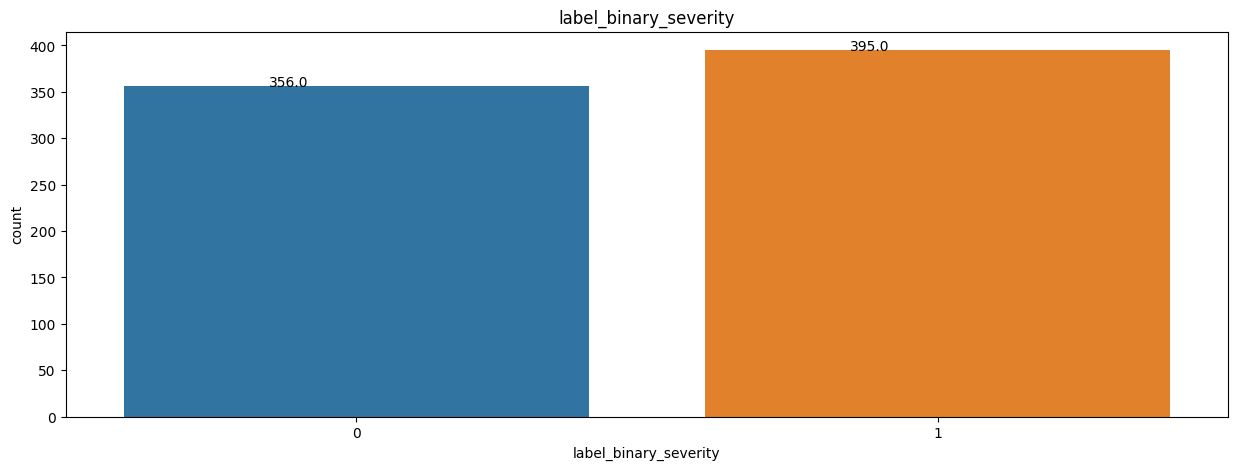

In [76]:
no_1_train=len(train.query(f"{labelCol}==1"))
no_1_test=len(test.query(f"{labelCol}==1"))
print(f"1(Critical) in Train={no_1_train} and  1(Critical) in Test={no_1_test}")

print(f"Train: Ratio of 1(Critical) to AllLabels is {round(no_1_train/len(train),2)}")
print(f"Test: Ratio of 1(Critical) to AllLabels is {round(no_1_test/len(test),2)}")

import seaborn as sns
import matplotlib.pyplot  as plt
def plot_label(df_):

    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df_,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol)
    plt.show()
        
plot_label(train)
plot_label(test)

In [77]:
train.tail(5)

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
2999,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,306.583333
3000,1,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,2247.850000
3001,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,21.883333
3002,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,Configuration Change,119.616667
3003,1,24x7 6Hrs Resolution Time,Software,Trend Micro,Incident,General Incident,13.316667


In [78]:
test.tail()

,label_binary_severity,sla,product_type,brand,service_type,incident_type,open_to_close_hour
746,0,24x7 4Hrs Response Time,Software,Trend Micro,Request,Software,0.650000
747,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,General Incident,16.983333
748,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,Software,289.683333
749,0,24x7 4Hrs Response Time,Software,Trend Micro,Incident,Software,28.550000
750,1,24x7 4Hrs Response Time,Security,Trend Micro,Incident,Software,51.166667


# Convert dataframe to tensorflow dataset

In [79]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=labelCol)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=labelCol)

# Build Model

In [80]:
# Specify the model.
if model_tree_type==1:
    print(f"GradientBoostedTreesModel and HyperparameterTemplate={hyperparameter_template}")
    #https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel
    if hyperparameter_template:
     model=tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
    else:
     model=tfdf.keras.GradientBoostedTreesModel()
else:
    print(f"RandomForestModel and HyperparameterTemplate={hyperparameter_template}")
    if hyperparameter_template:
     model = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")
    else:
       model = tfdf.keras.RandomForestModel()  
 
print("List hyperparameter")   
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())


GradientBoostedTreesModel and HyperparameterTemplate=False
Use /var/tmp/tmpsyf84zjz as temporary training directory
List hyperparameter
[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


[WARNING 23-11-18 07:46:23.2363 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 07:46:23.2378 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-11-18 07:46:23.2383 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [81]:
model.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:00.174060. Found 3004 examples.
Training model...


2023-11-18 07:46:24.294694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype string and shape [3004]
	 [[{{node Placeholder/_3}}]]


Model trained in 0:00:00.205949
Compiling model...
Model compiled.


[INFO 23-11-18 07:46:24.6576 UTC kernel.cc:1243] Loading model from path /var/tmp/tmpsyf84zjz/model/ with prefix 47a1c30889c5444a
[INFO 23-11-18 07:46:24.6677 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-11-18 07:46:24.6686 UTC kernel.cc:1075] Use fast generic engine
2023-11-18 07:46:24.679593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype int64 and shape [3004]
	 [[{{node Placeholder/_6}}]]


In [92]:
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
# https://keras.io/api/metrics/classification_metrics/
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall
rc_pc_thresholds=0.5

myMetrics=[
           tf.keras.metrics.BinaryAccuracy(threshold=rc_pc_thresholds)
           #tf.keras.metrics.BinaryAccuracy()
           ,tf.keras.metrics.AUC()
           ,tf.keras.metrics.Precision(thresholds=rc_pc_thresholds)
           ,tf.keras.metrics.Recall(thresholds=rc_pc_thresholds)]

model.compile(metrics=myMetrics)
evaluation = model.evaluate(test_ds, return_dict=True)
for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 603ms/step - loss: 0.0000e+00 - binary_accuracy: 0.8109 - auc_9: 0.8826 - precision_9: 0.8303 - recall_9: 0.8051
loss: 0.0000
binary_accuracy: 0.8109
auc_9: 0.8826
precision_9: 0.8303
recall_9: 0.8051


# Inspect and debug decision forest models
## Model structure and feature importance

In [85]:
inspector=model.make_inspector()

print("Model type:", inspector.model_type())
print("Number of trees:", inspector.num_trees())
print("Objective:", inspector.objective())
print("Input features:", inspector.features())

#[field for field in dir(inspector) if not field.startswith("_")]
# SUM_SCORE ,NUM_AS_ROOT

Model type: GRADIENT_BOOSTED_TREES
Number of trees: 52
Objective: Classification(label=__LABEL, class=None, num_classes=2)
Input features: ["brand" (4; #1), "incident_type" (4; #2), "open_to_close_hour" (1; #3), "product_type" (4; #4), "service_type" (4; #5), "sla" (4; #6)]


In [86]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT


# Model Self Evaluation

In [87]:
inspector.evaluation()

Evaluation(num_examples=None, accuracy=0.8421052694320679, loss=0.7912757396697998, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

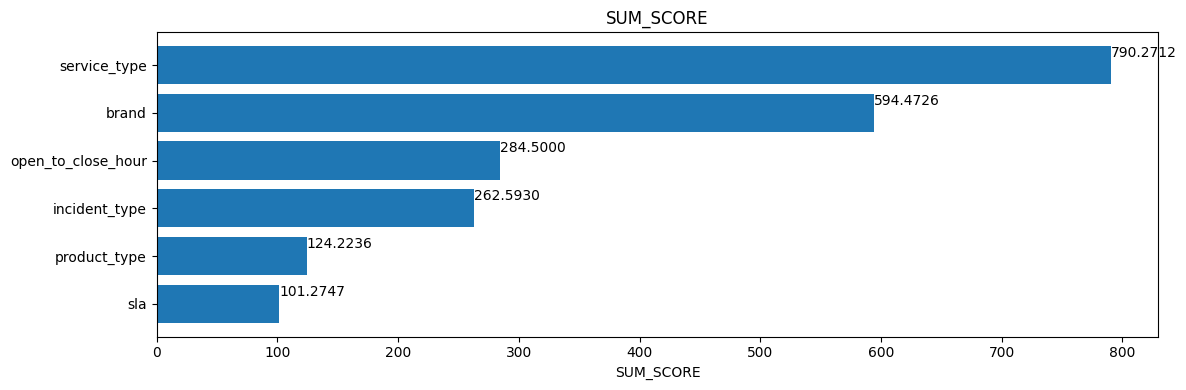

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "SUM_SCORE"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title(variable_importance_metric)
plt.tight_layout()
plt.show()

# Plot the model

In [89]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=4)

# Examine log training

In [90]:
logs = inspector.training_logs()


# Plotting the training logs

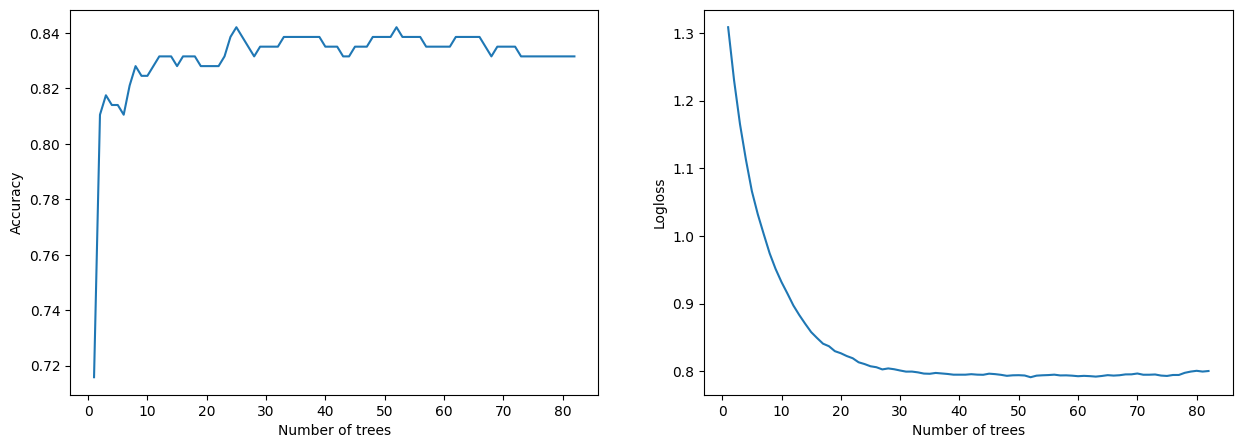

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss")

plt.show()

In [22]:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/save_and_load.ipynb#scrollTo=jFcuzsI94bNA
#save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
# model.save(model_gs_path,options=save_options)
# model.save(model_local_path,options=save_options)
model.save(model_gs_path)

INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_binary_gbt_tf_model/assets


INFO:tensorflow:Assets written to: gs://demo2-tf-incident-pongthorn/demo2_binary_gbt_tf_model/assets


In [23]:
# To Tensorbord
#inspector.export_to_tensorboard(f"./tb_logs/{_model}")